## GRU方法进行giekus模型的训练和预测,这个文件主要包括线性应变模型，可训练，可绘图

In [1]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
current_directory = os.getcwd()
print(current_directory)

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/share/users/fxy/work/Constitutive_Equation/stress_strain_fitting
Using GPU: NVIDIA GeForce RTX 3090


In [3]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取数据
url = 'data/giesekus_model_test_data.xlsx'

df = pd.read_excel(url, sheet_name=None)
data_HF = [[k, v] for k, v in df.items()]  # k is the sheet name, v is the pandas df
# 循环遍历 data_HF 列表并获取下标
data_train=pd.DataFrame()
data_valid=pd.DataFrame()
for i, (sheet_name, sheet_data) in enumerate(data_HF):
    if i==3:
        # 假设 sheet_data 是一个 DataFrame
        half_length = len(sheet_data) // 5
        sheet_data = sheet_data.iloc[:half_length]
        data_valid=sheet_data   
        data_train=pd.concat([data_train, sheet_data], ignore_index=True)

df_hf = pd.concat([data_train, data_valid], ignore_index=True)
x1_np=data_train['Time'].values
x2_np=data_train['γd12'].values
y1_np=data_train['σ11'].values
y2_np=data_train['σ22'].values
y3_np=data_train['σ12'].values
data_np = np.stack((x1_np, x2_np, y1_np, y2_np, y3_np), axis=1)

# 初始化 MinMaxScaler
scaler = MinMaxScaler()
# 对数据进行归一化
data_normalized = scaler.fit_transform(data_np)
# 分离归一化后的数据
x1_normalized = data_normalized[:, 0]
x2_normalized = data_normalized[:, 1]
y1_normalized = data_normalized[:, 2]
y2_normalized = data_normalized[:, 3]
y3_normalized = data_normalized[:, 4]

# 将归一化后的数据转换为 PyTorch 张量
x1_d_HF = torch.tensor(x1_normalized, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(x2_normalized, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(y1_normalized, dtype=torch.float32).view(-1, 1)
y2_d_HF = torch.tensor(y2_normalized, dtype=torch.float32).view(-1, 1)
y3_d_HF = torch.tensor(y3_normalized, dtype=torch.float32).view(-1, 1)

# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF], dim=1)
y_data_HF = torch.cat([y1_d_HF,y2_d_HF,y3_d_HF], dim=1)  
# 合并 X_data_HF 和 y_data_HF
Xy_data_HF = torch.cat([X_data_HF, y_data_HF], dim=1)

# 打印结果
print("X_data_HF shape:", X_data_HF.shape)
print("y_data_HF shape:", y_data_HF.shape)
print("Xy_data_HF shape:", Xy_data_HF.shape)

# 定义模型
in_dim, out_dim = 2, 3

X_data_HF shape: torch.Size([200, 2])
y_data_HF shape: torch.Size([200, 3])
Xy_data_HF shape: torch.Size([200, 5])


### 通过滑动窗口构建序列数据

In [4]:
# 定义时间步长
time_steps = 1
# 动态窗口实现
def create_dynamic_window(data, time_steps):
    """
    通过动态窗口将数据调整为适合 LSTM 输入的格式。
    :param data: 输入数据，形状为 (num_samples, ...)
    :param time_steps: 时间步长
    :return: 调整后的数据，形状为 (num_samples - time_steps + 1, time_steps, ...)
    """
    num_samples = data.shape[0]
    if num_samples < time_steps:
        raise ValueError("样本数量必须大于等于时间步长")
    
    # 创建动态窗口
    windowed_data = []
    for i in range(num_samples - time_steps+1):
        window = data[i:i + time_steps]
        windowed_data.append(window)
    
    return torch.stack(windowed_data)

# 调整 X_data_HF
X_data_HF = create_dynamic_window(X_data_HF, time_steps)

# 调整 y_data_HF
# 注意：y_data_HF 通常是目标值，只需要取最后一个时间步的值
y_data_HF = y_data_HF[time_steps-1:]
print(X_data_HF.shape)
print(y_data_HF.shape)

torch.Size([200, 1, 2])
torch.Size([200, 3])


In [5]:

# 验证集数据
x1_valid_np=data_valid['Time'].values
x2_valid_np=data_valid['γd12'].values
y1_valid_np=data_valid['σ11'].values
y2_valid_np=data_valid['σ22'].values
y3_valid_np=data_valid['σ12'].values
# 将验证集数据组合成一个二维数组
valid_data_np = np.stack((x1_valid_np, x2_valid_np, y1_valid_np,y2_valid_np,y3_valid_np), axis=1)
# 使用训练集的 scaler 对验证集数据进行归一化
valid_data_normalized = scaler.transform(valid_data_np)
# 分离归一化后的验证集数据
x1_valid_normalized = valid_data_normalized[:, 0]
x2_valid_normalized = valid_data_normalized[:, 1]
y1_valid_normalized = valid_data_normalized[:, 2]
y2_valid_normalized = valid_data_normalized[:, 3]
y3_valid_normalized = valid_data_normalized[:, 4]
# 将归一化后的验证集数据转换为 PyTorch 张量
x1_d_valid = torch.tensor(x1_valid_normalized, dtype=torch.float32).view(-1, 1)
x2_d_valid = torch.tensor(x2_valid_normalized, dtype=torch.float32).view(-1, 1)
y1_d_valid = torch.tensor(y1_valid_normalized, dtype=torch.float32).view(-1, 1)
y2_d_valid = torch.tensor(y2_valid_normalized, dtype=torch.float32).view(-1, 1)
y3_d_valid = torch.tensor(y3_valid_normalized, dtype=torch.float32).view(-1, 1)

# 合并数据
X_data_valid = torch.cat([x1_d_valid, x2_d_valid], dim=1)
y_data_valid = torch.cat([y1_d_valid,y2_d_valid,y3_d_valid], dim=1)

In [ ]:
# 调整 X_data_valid
X_data_valid = create_dynamic_window(X_data_valid, time_steps)
# 调整 y_data_HF
# 注意：y_data_HF 通常是目标值，只需要取最后一个时间步的值
y_data_valid = y_data_valid[time_steps-1:]
print(X_data_valid.shape)
print(y_data_valid.shape)

torch.Size([200, 1, 2])
torch.Size([200, 3])


In [7]:
class GRU_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model using GRU."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 hidden_size=20,  # GRU 隐藏层的维度
                 num_layers=4,    # GRU 层数
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(GRU_NeuralNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # 添加 GRU 层
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first=True)
        
        # 添加第一层全连接层（从 GRU 的隐藏状态映射到中间层）
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # 中间层的维度可以与 hidden_size 相同
        
        # 添加第二层全连接层（从中间层映射到输出维度）
        self.out = nn.Linear(hidden_size, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(param)
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):
        # GRU 输入形状: (batch_size, seq_len, input_dim)
        # GRU 输出形状: (batch_size, seq_len, hidden_size)
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        
        # 通过 GRU 层
        gru_out, _ = self.gru(X, h0)
        
        # 取最后一个时间步的输出
        last_time_step = gru_out[:, -1, :]  # (batch_size, hidden_size)
        
        # 通过第一层全连接层
        Z = self.fc1(last_time_step)
        
        # 应用激活函数（如果需要）
        if self.activation is not None:
            Z = self.activation(Z)
        
        # 通过第二层全连接层
        Z = self.out(Z)
        
        return Z

In [8]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model):
        self.model = model # 
        # Initialize history of losses and global iteration counter
        self.hist =  [[], []] # loss历史列表,0:train loss ;1:valid loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_data_valid,y_data_valid):
        y_pred_valid = self.model(X_data_valid)    
    
        y_pred_HF = self.model(X_data_HF)

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model.parameters())
        # 计算高频数据集的 Huber Loss
        Loss_data_HF = F.smooth_l1_loss(y_pred_HF[:,2], y_data_HF[:,2]) 
    
        # 计算验证集的 Huber Loss
        Loss_data_valid = F.smooth_l1_loss(y_pred_valid[:,2], y_data_valid[:,2]) 
        return Loss_data_HF,Loss_data_valid
    
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer, data, scheduler, batch_size, N=1001):
        """This method performs a gradient descent type optimization."""
        # 解包数据
        X_data_HF, y_data_HF, X_data_valid, y_data_valid = data

        # 创建训练数据集和 DataLoader
        train_dataset = TensorDataset(X_data_HF, y_data_HF)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        for i in range(N):
            # 初始化 epoch 的总损失
            epoch_loss_sum = 0.0
            num_batches = 0
            # 遍历每个批次
            for X_batch, y_batch in train_loader:
                # 梯度清0
                optimizer.zero_grad()
                # 计算 loss
                loss, _ = self.loss_fn(X_batch, y_batch, X_data_valid, y_data_valid)

                # 反向传播计算梯度
                loss.backward()

                # 反向传播更新权重和偏置
                optimizer.step()

                # 累加每个批次的损失
                epoch_loss_sum += loss.item()
                num_batches += 1

            # 计算 epoch 的平均损失
            # 在整个验证集上计算验证损失
            loss_train, loss_valid = self.loss_fn(X_data_HF, y_data_HF, X_data_valid, y_data_valid)

            # 记录 epoch 的平均损失
            self.current_loss = loss_train.item()
            self.valid_loss = loss_valid.item()
            # 根据 epoch 的平均损失调度学习率
            scheduler.step(loss_train)
            
            # 计算相对误差
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error, N)  # 将 max_relative_error 传递给回调函数
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3:  # 以 % 为单位
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                                                                    self.current_loss,
                                                                                                    np.round(self.max_relative_error, 3)))
                break
    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 10 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.valid_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='Validation Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [9]:
model= GRU_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_layers=4,
                             hidden_size=10,
                             activation='relu')

# 初始化 PINNSolver
solver = PINNSolver(model)
model = model.to(device)  # 将模型移动到 GPU
X_data_HF,y_data_HF,X_data_valid,y_data_valid
# 假设 X_data_HF, y_data_HF, X_data_valid, y_data_valid 是 PyTorch 张量
X_data_HF = X_data_HF.to(device)  # 将训练集输入数据移动到 GPU
y_data_HF = y_data_HF.to(device)  # 将训练集标签数据移动到 GPU

X_data_valid = X_data_valid.to(device)  # 将验证集输入数据移动到 GPU
y_data_valid = y_data_valid.to(device)  # 将验证集标签数据移动到 GPU

## 下面是论文绘图的代码，需要修改的地方有：


In [10]:

# 假设你已经使用了 GPU
x = torch.randn(10, 10).cuda()

# 清空未使用的显存缓存
torch.cuda.empty_cache()

In [ ]:
current_directory = os.getcwd()
print(current_directory)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
%config InlineBackend.figure_format = 'svg' # 修改出图为svg矢量图
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")


/share/users/fxy/work/Constitutive_Equation/stress_strain_fitting
已加载用户自定义 Arial 字体


## sigma12

<ipython-input-12-e67ced149100>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dnn_12=torch.load('model/giesukus_dnn_linear.pth')
<ipython-input-12-e67ced149100>:2: 

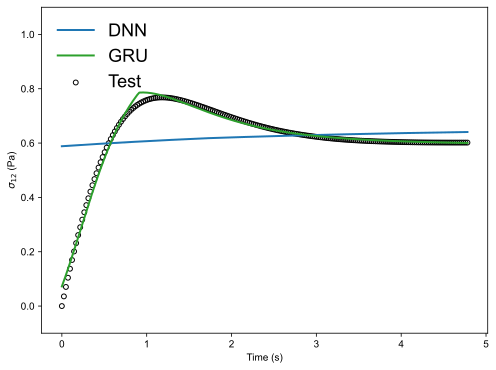

In [12]:

model_dnn_12=torch.load('model/giesukus_dnn_linear.pth')
model_gru_12=torch.load('model/giesukus_gru_linear.pth')
model_dnn_12.eval()
model_gru_12.eval()
# 统一设置字体为 Arial 24 pt
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24 # 三拼图为36，单图为12最佳
# 颜色字典
colors = {
    'red': 'tab:red',
    'orange': 'tab:orange',
    'yellow': '#f9c74f',
    'green': 'tab:green',
    'cyan': 'tab:cyan',
    'blue': 'tab:blue',
    'purple': 'tab:purple',
    'brown': 'tab:brown',
    'pink': 'tab:pink',
    'black': '#000000'  # 添加黑色
}


y_dnn = model_dnn_12(X_data_valid) 
y_gru = model_gru_12(X_data_valid) 
# 反归一化 y_MF
y_dnn=y_dnn.cpu().detach().numpy()
y_gru=y_gru.cpu().detach().numpy()
# 提取后三列的归一化参数
y_min = scaler.data_min_[-3:]  # 后三列的最小值
y_max = scaler.data_max_[-3:]  # 后三列的最大值
# 手动反归一化
y_dnn_denorm = y_dnn * (y_max - y_min) + y_min
y_gru_denorm = y_gru * (y_max - y_min) + y_min
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
ax.plot(data_valid['Time'].values[time_steps-1:], y_dnn_denorm[:,2], color=colors['blue'],label='DNN',lw=2)
ax.plot(data_valid['Time'].values[time_steps-1:], y_gru_denorm[:,2], color=colors['green'],label='GRU',lw=2)

ax.scatter(data_valid['Time'].values[time_steps-1:], data_valid['σ12'].values[time_steps-1:], color=colors['black'], marker='o', 
            label='Test',s=24,facecolors='none')

    
ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.set_xlabel('Time (s)')
ax.set_ylim(-0.1,1.1)
# 调整图例的大小和位置
legend = ax.legend(fontsize=18, loc='upper left', frameon=False)
plt.show()

- 绘制残差图

<ipython-input-13-fb02d872e391>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dnn_12 = torch.load('model/giesukus_dnn_linear.pth')
<ipython-input-13-fb02d872e391>:6

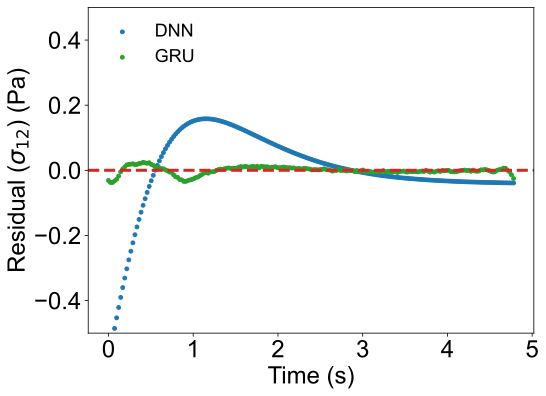

In [13]:
import matplotlib.pyplot as plt
import torch
from scipy.fftpack import fft, ifft
# 加载模型
model_dnn_12 = torch.load('model/giesukus_dnn_linear.pth')
model_gru_12 = torch.load('model/giesukus_gru_linear.pth')
model_dnn_12.eval()
model_gru_12.eval()

# 统一设置字体为 Arial 24 pt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24

# 颜色字典
colors = {
    'red': 'tab:red',
    'orange': 'tab:orange',
    'yellow': '#f9c74f',
    'green': 'tab:green',
    'cyan': 'tab:cyan',
    'blue': 'tab:blue',
    'purple': 'tab:purple',
    'brown': 'tab:brown',
    'pink': 'tab:pink',
    'black': '#000000'
}
# 预测
y_dnn = model_dnn_12(X_data_valid)
y_gru = model_gru_12(X_data_valid)

# 反归一化
y_dnn = y_dnn.cpu().detach().numpy()
y_gru = y_gru.cpu().detach().numpy()
y_min = scaler.data_min_[-3:]  # 后三列的最小值
y_max = scaler.data_max_[-3:]  # 后三列的最大值
y_dnn_denorm = y_dnn * (y_max - y_min) + y_min
y_gru_denorm = y_gru * (y_max - y_min) + y_min

# 计算残差
residual_dnn = data_valid['σ12'].values[time_steps-1:] - y_dnn_denorm[:, 2]
residual_gru = data_valid['σ12'].values[time_steps-1:] - y_gru_denorm[:, 2]
# 1. 提取周期性信号（使用傅里叶变换）
def extract_periodic_signal(data, threshold=0.1):
    # 傅里叶变换
    fft_data = fft(data)
    frequencies = np.fft.fftfreq(len(data))
    
    # 过滤高频成分（保留低频周期性成分）
    fft_data[np.abs(frequencies) > threshold] = 0
    
    # 逆傅里叶变换得到周期性信号
    periodic_signal = np.real(ifft(fft_data))
    return periodic_signal

periodic_signal = extract_periodic_signal(residual_gru)

# 2. 生成正态分布噪声
mean = np.mean(residual_gru)
std = np.std(residual_gru)
normal_noise = np.random.normal(mean, std, size=len(residual_gru))

# 3. 结合周期性信号和正态分布噪声
alpha = 0.9  # 控制周期性信号的强度
normalized_residuals = alpha * periodic_signal + (1 - alpha) * normal_noise

# 绘制残差曲线
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
ax.scatter(data_valid['Time'].values[time_steps-1:], residual_dnn, color=colors['blue'], label='DNN', s=15)
ax.scatter(data_valid['Time'].values[time_steps-1:], normalized_residuals, color=colors['green'], label='GRU', s=15)

# 添加红色基准线
ax.axhline(0, color=colors['red'], linestyle='--', lw=3)

# 设置标签和图例
ax.set_ylabel('Residual ($\sigma_{12}$) (Pa)')
ax.set_xlabel('Time (s)')
legend = ax.legend(fontsize=18, loc='upper left', frameon=False)
ax.set_ylim(-0.5,0.5)
plt.show()

- 绘制线性指标图

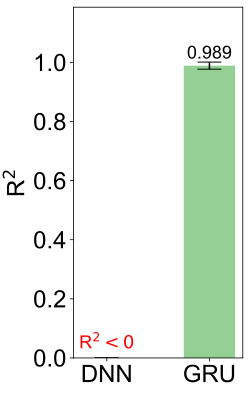

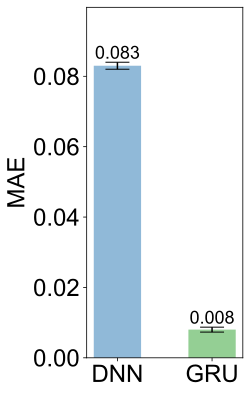

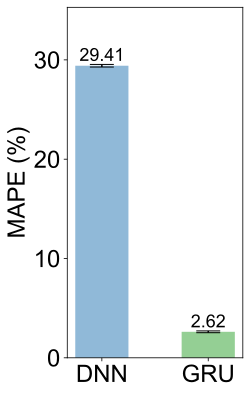

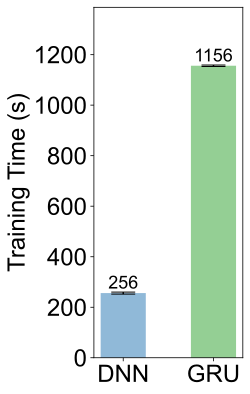

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 示例数据（请根据实际情况替换）
metrics = [f'R$^{2}$', 'MAE', 'MAPE', 'Training Time']
dnn_values = [-76.1, 0.083, 29.41, 256]  # 示例DNN值
gru_values = [0.989, 0.008, 2.62, 1156]  # 示例GRU值

# 误差棒（请根据实际情况替换）
dnn_errors = [0, 0.001, 0.13, 4]  # DNN的误差
gru_errors = [0.012, 0.0007, 0.09, 3]  # GRU的误差

# Nature 科研配色
dnn_color = '#377eb8'  # 蓝色
gru_color = 'tab:green'  # 绿色

# 自定义渐变颜色
def create_gradient_cmap(color1, color2, gamma=2.0, N=256):
    """
    创建渐变颜色映射
    :param color1: 渐变的起点颜色
    :param color2: 渐变的终点颜色
    :param gamma: 控制渐变的平滑度
    :param N: 渐变的分辨率
    :return: 渐变颜色映射
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=N)
    cmap._init()
    cmap._lut[:, -1] = np.linspace(0, 1, cmap.N + 3) ** gamma  # 调整透明度
    return cmap

# 柱状图宽度
bar_width = 0.1

# 绘图
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(4, 6), dpi=600)
    
    # 计算柱状图位置
    x = [1, 1.2]  # 2 个模型：DNN 和 GRU
    
    # 创建渐变颜色映射
    dnn_cmap = create_gradient_cmap('lightblue', dnn_color)
    gru_cmap = create_gradient_cmap('white', gru_color)
    
    # 绘制DNN柱状图
    if dnn_values[i] > 0:
        dnn_bar = ax.bar(x[0], dnn_values[i], width=bar_width, color=dnn_cmap(0.8), yerr=dnn_errors[i], capsize=12, label='DNN')
    else:
        dnn_bar = ax.bar(x[0], 0, width=bar_width, color=dnn_cmap(0.8), yerr=dnn_errors[i], capsize=12, label='DNN')
        ax.text(x[0], 0.02, 'R$^{2}<0$', color='red', ha='center', va='bottom', fontsize=18)  # 标记异常值
    
    # 绘制GRU柱状图
    gru_bar = ax.bar(x[1], gru_values[i], width=bar_width, color=gru_cmap(0.8), yerr=gru_errors[i], capsize=12, label='GRU')
    
    # 显示柱状图数字
    for bar, error in zip([dnn_bar, gru_bar], [dnn_errors[i], gru_errors[i]]):
        for rect in bar:
            height = rect.get_height()
            if height == 0:
                continue  # 如果高度为0，跳过显示
            # 显示数值，位置为柱状图高度 + 误差棒高度 + 额外偏移
            ax.text(
                rect.get_x() + rect.get_width() / 2.0,  # x 位置：柱状图中心
                height + error,  # y 位置：柱状图高度 + 误差棒高度 + 额外偏移
                f'{height}',  # 显示数值，保留两位小数
                ha='center',  # 水平居中
                va='bottom',  # 垂直底部对齐
                fontsize=18  # 字体大小
            )
    
    # 设置y轴标签
    if i == 2:
        ax.set_ylabel(metric + ' (%)')
    elif i == 3:
        ax.set_ylabel(metric + ' (s)')
    else:
        ax.set_ylabel(metric)
    
    # 设置x轴标签
    ax.set_xticks(x)
    ax.set_xticklabels(['DNN', 'GRU'])  # x轴显示DNN和GRU
    
    # 调整y轴范围，留出更多空白
    max_value = max(dnn_values[i], gru_values[i])  # 获取当前指标的最大值
    ax.set_ylim(0, max_value * 1.2)  # 设置y轴上限为最大值的1.2倍
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()

- 绘制不同时间步，线性指标变化

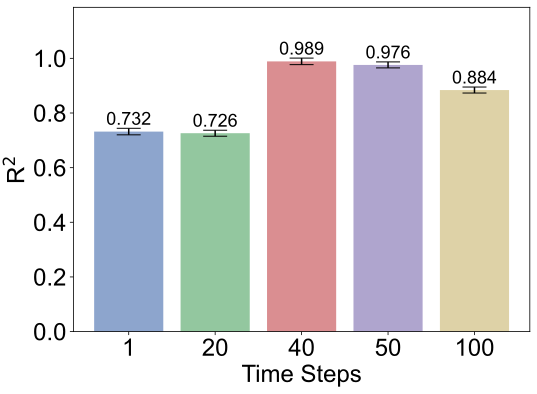

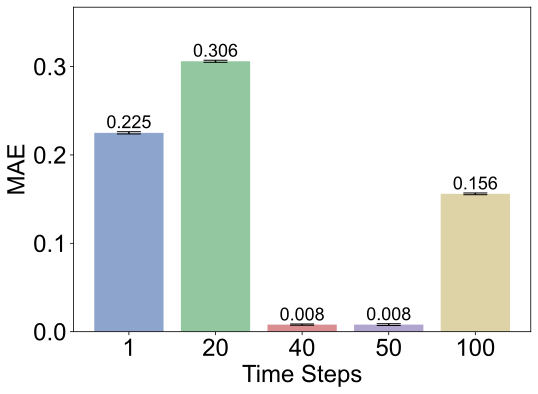

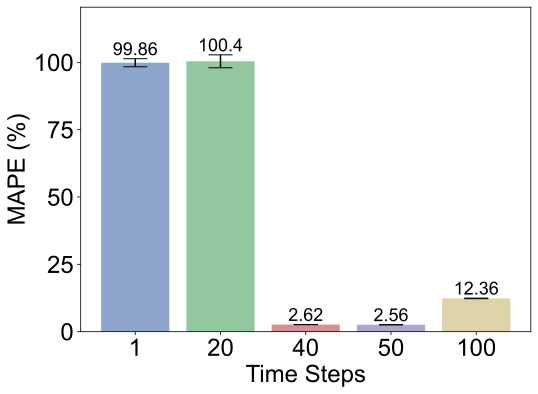

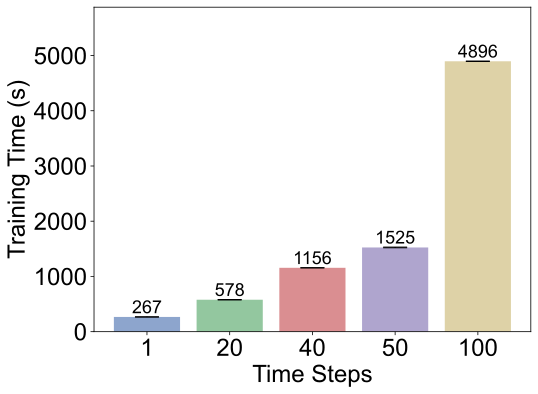

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 示例数据（请根据实际情况替换）
metrics = [f'R$^{2}$', 'MAE', 'MAPE', 'Training Time']
values = [
    [0.732, 0.726, 0.989, 0.976, 0.884],  # 示例值，替换为实际数据
    [0.225, 0.306, 0.008, 0.008, 0.156],  # 示例值，替换为实际数据
    [99.86, 100.4, 2.62, 2.56, 12.36],  # 示例值，替换为实际数据
    [267, 578, 1156, 1525, 4896]                    # 示例值，替换为实际数据
]

# 误差棒（请根据实际情况替换）
errors = [
    [0.012, 0.011, 0.012, 0.011, 0.011],  # 示例误差，替换为实际数据
    [0.0013, 0.0012, 0.0007, 0.001, 0.001],  # 示例误差，替换为实际数据
    [1.5, 2.4, 0.04, 0.02, 0.11],  # 示例误差，替换为实际数据
    [3, 4, 3, 6, 4, 4]  # 示例误差，替换为实际数据
]

# 自定义渐变颜色
def create_gradient_cmap(color1, color2, gamma=1.0, N=256):
    """
    创建渐变颜色映射
    :param color1: 渐变的起点颜色
    :param color2: 渐变的终点颜色
    :param gamma: 控制渐变的平滑度
    :param N: 渐变的分辨率
    :return: 渐变颜色映射
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=N)
    cmap._init()
    cmap._lut[:, -1] = np.linspace(0, 1, cmap.N + 3) ** gamma  # 调整透明度
    return cmap

# 柱状图宽度
bar_width = 0.8

# 横坐标
x_ticks = [1, 2, 3, 4, 5]  # 实际刻度
x_labels = [1, 20, 40, 50,100]  # 实际显示的标签

# Nature风格配色
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

# 绘图
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # 绘制柱状图
    bars = []
    for j, x in enumerate(x_ticks):
        # 创建渐变颜色映射
        cmap = create_gradient_cmap('white', colors[j])
        bar = ax.bar(x, values[i][j], width=bar_width, color=cmap(0.8), yerr=errors[i][j], capsize=12)
        bars.append(bar)
    
    # 显示柱状图数字
    for bar in bars:
        for rect in bar:
            height = rect.get_height()
            error = errors[i][bars.index(bar)]  # 获取对应的误差值
            if i != 3:
                ax.text(rect.get_x() + rect.get_width() / 2.0, height+error, f'{height}', ha='center', va='bottom', fontsize=18)
            else:
                ax.text(rect.get_x() + rect.get_width() / 2.0, height+error, f'{height}', ha='center', va='bottom', fontsize=18)
    
    # 设置y轴标签
    if i == 2:
        ax.set_ylabel(metric+ ' (%)')
    elif i==3:
        ax.set_ylabel(metric + ' (s)')
    else:
        ax.set_ylabel(metric)
    # 设置x轴标签
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Time Steps')
    # 调整y轴范围，留出更多空白
    max_value = max(values[i])  # 获取当前指标的最大值
    ax.set_ylim(0, max_value * 1.2)  # 设置y轴上限为最大值的1.2倍
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()